In [224]:
# Import some of the basis required functions
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import networkx as nx
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll


<h3>Simulation of normally distributed stock prices</h3>

In [210]:
def question1(N_simulations, output=True, seed = False, outputname='', monthly_daily='month'):
    if type(seed)==int:
        np.random.seed(seed)
    # We have the following model for monthly stock price returns
    # ln(S_t+1 / S_t) = mu + sigma * epsilon
    # a) simulate 1000 paths for the 1 year stock return
    mu = 5e-3
    sigma = 5e-2
    if monthly_daily == 'month':
        log_monthly_returns = mu + sigma * np.random.randn(N_simulations,12)
        log_year_return    = np.sum(log_monthly_returns,axis=1)
        
    elif monthly_daily == 'day':
        log_daily_returns = np.random.randn(N_simulations,253)*sigma/np.sqrt(21) + mu/21
        log_year_return    = np.sum(log_daily_returns,axis=1)
       
    # Get distribution stats
    distr_mu = np.round(np.mean(log_year_return),4)
    stddev   = np.round(np.std(log_year_return),4)
    if output:
        print('Realized annual return (Average): {:1.2f}%'.format(distr_mu*100))
    # Plot results

    if output:
        fig,ax = plt.subplots()
        label = r'$\mu={}%$'.format(distr_mu*100)+'\n'+'$\sigma=${}%'.format(stddev*100)
        ax.hist(log_year_return, bins='auto',label=label,fill=False,
                histtype='step',color='black',lw=2)
        ax.set_xlabel('Yearly log-return', size=13)
        ax.set_ylabel('Frequency', size=13)
        plt.legend()
        if len(outputname)>0:
            plt.savefig(outputname)

    # Derive one year expected stock return
    expected_mu  = (5e-3*12)*100
    expected_std = np.sqrt(12)*5/np.sqrt(N_simulations)
    if output:
        print('Expected annual return {:1.2f}% and expected annual std {:1.2f}%'.
           format(expected_mu,expected_std))
    z_99 = 2.576
    conf_interval = np.round([expected_mu-z_99*expected_std,expected_mu+z_99*expected_std],3)
    if output:
        print('99% confidence interval:',conf_interval)
    return np.mean(log_year_return)

Realized annual return (Average): 5.64%
Expected annual return 6.00% and expected annual std 0.55%
99% confidence interval: [4.589 7.411]


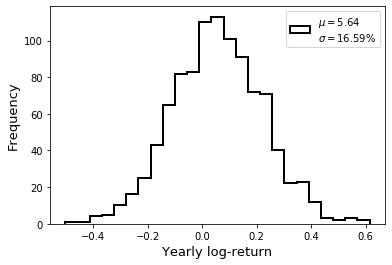

In [211]:
# 1a)
_ = question1(int(1e3), True, 42, 'Q1a.pdf')

Realized annual return (Average): 6.00%
Expected annual return 6.00% and expected annual std 0.24%
99% confidence interval: [5.369 6.631]


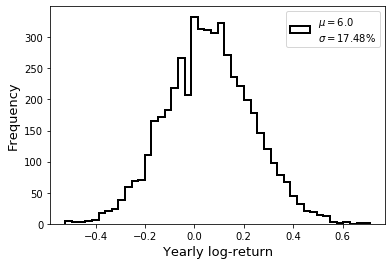

In [212]:
# 1b)
_ = question1(5000, True, 42, 'Q1b.pdf', monthly_daily='month')

Annual return (Average): 6.00%
Annual standard deviation (Average): 0.17%


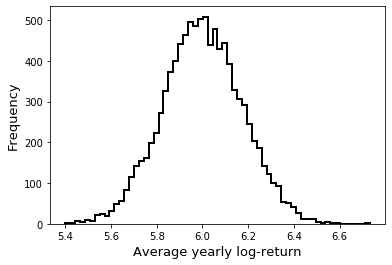

In [213]:
# 1c)
returns = 100*np.array([question1(10000,False,seed=True,monthly_daily='month') for w in range(10000)])
fig,ax = plt.subplots()
distr_mu = np.round(np.mean(returns),4)
stddev   = np.round(np.std(returns),4)
print('Annual return (Average): {:1.2f}%'.format(distr_mu))
print('Annual standard deviation (Average): {:1.2f}%'.format(stddev))
#label = r'$\mu={}$'.format(distr_mu)+'\n'+'$\sigma=${}'.format(distr_mu)
ax.hist(returns, bins='auto',fill=False,
        histtype='step',color='black',lw=2)
ax.set_xlabel('Average yearly log-return', size=13)
ax.set_ylabel('Frequency', size=13)
plt.savefig('Q1c.pdf')
plt.show()

<h3>Binomial Trees</h3>

In [214]:
# Download S&P500 data for 60 months, since 12*feb < 60
# We choose the daily closing prices. The ticker symbol for 
# the S&P is ^GSPC on Yahoo Finance.
sp500_pdaily = ffn.get('^GSPC:Close', start='2015-09-01',end='2020-08-31',)

# Convert the daily prices to monthly prices by taking the closing 
# value of each month (e.g. last trading day)
sp500_pmonthly = sp500_pdaily.to_monthly()

# Check length
print('Number of months equals {}'.format(len(sp500_pmonthly)))
sp500_rmonthly = sp500_pmonthly.to_returns()

Number of months equals 60


/home/luuk/anaconda3/lib/python3.7/site-packages/ffn/core.py:1388: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  res = orig.ix[dts.values]


In [215]:
def plot_SP():# Plot monthly returns
    fig,ax = plt.subplots()#figsize=(7,4))
    #ax.plot(sp500_rmonthly*100,color='grey',ls='--')
    ax.stem(sp500_rmonthly.index,sp500_rmonthly*100, basefmt='')
    ax.set_xlabel('Time (years + months)', size=13)
    ax.set_ylabel('Monthly return (%)', size=13)
    plt.tight_layout()
    plt.savefig('Q2a.pdf')

In [216]:
def summary_table():
    # Table with summary statistics
    sum_df = pd.DataFrame(columns = ['Statistic','Value']).set_index('Statistic')
    sum_df.loc['First date'] = sp500_rmonthly.index.min()
    sum_df.loc['Last date'] = sp500_rmonthly.index.max()
    sum_df.loc['Number of Months'] = len(sp500_rmonthly)
    sum_df.loc['Mean monthly return (%)'] = sp500_rmonthly.mean().values*100
    sum_df.loc['Monthly standard deviation (%)'] = sp500_rmonthly.std().values*100
    sum_df.loc['Minimum value S&P 500'] = sp500_pmonthly.min().values
    sum_df.loc['Maximum value S&P 500'] = sp500_pmonthly.max().values
    sum_df.loc['Performance best month'] = sp500_rmonthly.max().values*100
    sum_df.loc['Performance worst month'] = sp500_rmonthly.min().values*100
    return sum_df
summary_table()


,Value
Statistic,
First date,2015-09-30 00:00:00
Last date,2020-08-31 00:00:00
Number of Months,60
Mean monthly return (%),1.11405
Monthly standard deviation (%),4.28156
Minimum value S&P 500,1920.03
Maximum value S&P 500,3500.31
Performance best month,12.6844
Performance worst month,-12.5119


In [258]:
startingprice = sp500_pmonthly['gspcclose'].iloc[-1]
strikeprice = 3300
sigma = sp500_rmonthly.std().iloc[-1]

In [259]:
class BinomialTree():
    def __init__(self,N, T, S, sigma, r_year, K,ret_arrays=True, ret_option=False, call_put = 'call', risk_premium = 0):
        self.N = N
        self.T = T
        self.S = S
        self.sigma = sigma
        self.r_year = r_year
        self.K = K
        self.ret_arrays = ret_arrays
        self.ret_option = ret_option
        self.call_put = call_put
        self.risk_premium = risk_premium
        
        self.binomial_tree()

    def binomial_tree(self):
        """Calculates option values, prices and returns using binomial tree
           N: number of steps
           T: total time (in months)
           S: starting price in USD
           sigma: monthly volatility
           r: annual interest rate (note that I use quarterly compounding)
        """
        
        # Time steps given total duration and number of steps
        dt = self.T/self.N
        u = np.exp(self.sigma * np.sqrt(dt))
        print(self.sigma)
        d = 1/u
        r_dt = self.r_year / 12 * dt + self.risk_premium /3 * dt

        p = ((1+r_dt)-d)/(u-d)#(np.exp(r*dt)-d)/(u-d)
        pd = 1-p
        # Fill the tree
        price_tree = np.zeros([self.N+1,self.N+1])

        for i in range(self.N+1):
            for j in range(i+1):
                price_tree[j,i] = self.S*(d**j)*(u**(i-j))

        # Derive the option value
        option = np.zeros([self.N+1, self.N+1])
        if self.call_put == 'call':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),price_tree[:,self.N]-self.K)),axis=0)
        elif self.call_put == 'put':
            option[:,self.N] = np.max(np.vstack((np.zeros(self.N+1),self.K-price_tree[:,self.N])),axis=0)


        # Calculate option price at t=0

        for i in np.arange(self.N-1,-1,-1):
            for j in np.arange(0,i+1):
                option[j,i] = (1/(1+r_dt))*(p*option[j,i+1] + (1-p)*option[j+1,i+1])

        self.price_tree = price_tree
        self.option_tree = option
        self.option_value = option[0,0]
        
        if self.ret_arrays:
            return price_tree, option          
        if self.ret_option:
            return option[0,0]
        
    def plot_graph(self,data, filename):
        n = self.N
        fig, ax=plt.subplots(figsize=(7,5))
        G=nx.Graph()
        for i in range(0,n+1):
            for j in range(1,i+2):
                if i<n:
                    G.add_edge((i,j),(i+1,j))
                    G.add_edge((i,j),(i+1,j+1))

        posG={}

        for node in G.nodes:
            posG[node]=(node[0],n+2+node[0]-2*node[1])
        nx.draw(G,pos=posG, with_labels=False, ax=ax)

        dict_ = {}
        for node in G.nodes:
            dict_[node] = 0*' '+np.round(data[node[1]-1,node[0]],1).astype(str)
        labels=nx.draw_networkx_labels(G,pos=posG,labels=dict_, ax=ax,verticalalignment='bottom',
                                       horizontalalignment='right',bbox=dict(facecolor='w',alpha=.6))
        dict_ = {}
        for edge in G.edges:
            dict_[edge] = 'u' if edge[1][1]<=edge[0][1] else 'd'

        labels=nx.draw_networkx_edge_labels(G,pos=posG,edge_labels=dict_, ax=ax)


        plt.xlim(-0.4,n+0.2)
        plt.ylim(-0.4,6.4)
        plt.tight_layout()
        if filename is not '':
            plt.savefig(filename,dpi=500,bbox_inches='tight')
        return     


0.04281564231667559


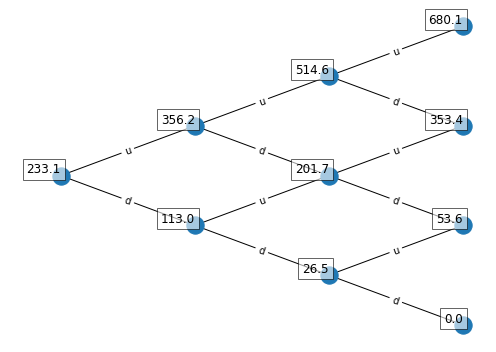

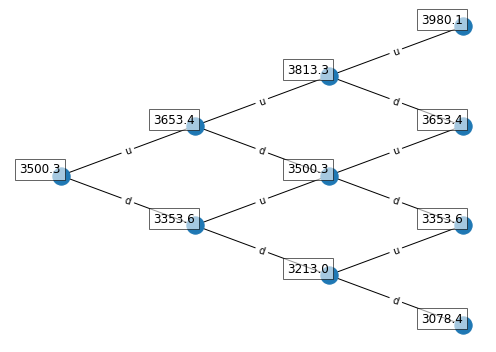

In [260]:
FirstBinomialTree = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='call')
FirstBinomialTree.plot_graph(FirstBinomialTree.option_tree, '2b_optiontree.pdf')
FirstBinomialTree.plot_graph(FirstBinomialTree.price_tree, '2b_stockprices.pdf')

In [261]:
def risk_neutral_valuation():# 2c
    riskfree = 0.005/12 #year -> month
    risk_premium = 0.01/3 # quarter -> month
    u = np.exp(sigma)
    d = 1/u
    p = ((1+riskfree)+risk_premium-d)/(u-d)
    return p
risk_neutral_valuation()

0.5330767534750636

In [262]:
# 2d
from scipy.stats import norm
def black_scholes(S, K, T, r, sigma, call_put='call'):   
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    if call_put == 'call':
        optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    elif call_put == 'put':
        optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
    return optionprice

black_scholes(startingprice, 3300, 3, 0.005/12, sigma)

234.0904916882596

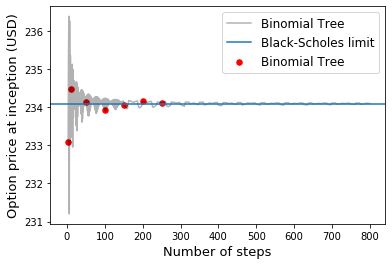

In [263]:
class convergence():
    def __init__(self):
        # Run in parallel
        # Define Ns
        self.manyN = np.hstack((np.linspace(3,150,500,dtype=int),
                                np.linspace(150,800,300,dtype=int)))
        self.scatterN = np.array([3,10,50,100,150,200,250])
        
    def get_BN_option_value(self,N):
        btree = BinomialTree(N,3,startingprice,sigma,0.005,3300,call_put='call')
        return btree.option_value

    def iterate(self):
        self.option_prices = Parallel(n_jobs=7)(delayed(self.get_BN_option_value)(N) for N in self.manyN)
        self.option_prices_scatter = Parallel(n_jobs=7)(delayed(self.get_BN_option_value)(N) for N in self.scatterN)
        
    def plot(self):
        plt.figure()
        plt.plot(self.manyN, self.option_prices, color='black', label='Binomial Tree',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of steps', size=13)
        plt.scatter(self.scatterN, self.option_prices_scatter, color='red', label='Binomial Tree',s=30)
        plt.axhline(black_scholes(startingprice, 3300, 3, 0.005/12, sigma), label='Black-Scholes limit')
        plt.legend(loc='best', fontsize=12)
        plt.savefig('BS_tree_convergence.pdf', dpi=500)
    
BS_vs_BT = convergence()                                           
BS_vs_BT.iterate()
BS_vs_BT.plot()

0.04281564231667559


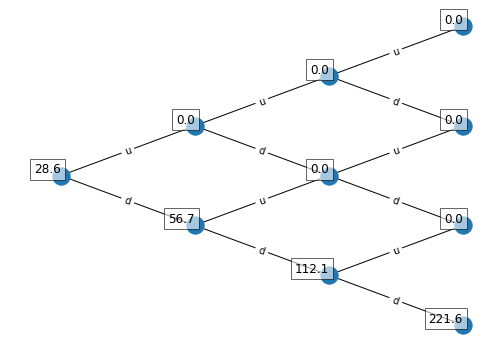

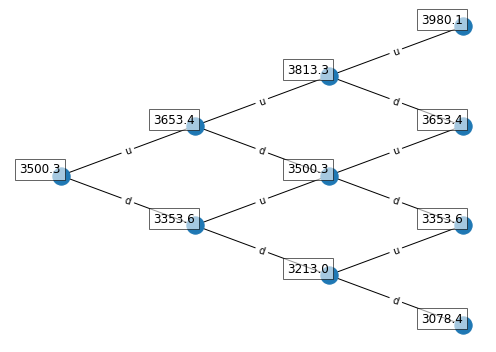

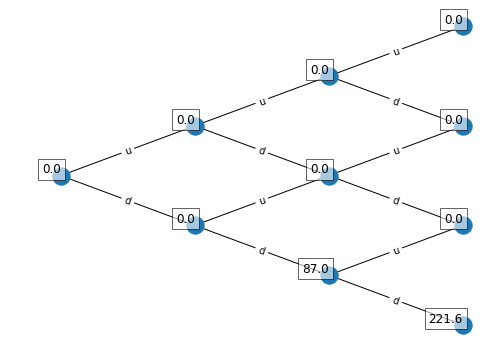

In [264]:
Binomial_2f = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='put')
Binomial_2f.plot_graph(Binomial_2f.option_tree, '2f_optiontree.pdf')
Binomial_2f.plot_graph(Binomial_2f.price_tree, '2f_stockprices.pdf')
Binomial_2f.plot_graph(np.maximum(3300-Binomial_2f.price_tree,0), '2f_payout.pdf')

In [265]:
def put_call_parity():
    # Check the call put parity
    # derive call value at inception
    parity_call = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='call').option_value
    # derive put value at inception
    parity_put = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='put').option_value
    # discount strikeprice using non-compounding interest
    PV = strikeprice * (1+0.005/4)**(-1)
    # compare LHS and RHS
    print('LHS', parity_call+PV)
    print('RHS', parity_put+startingprice)
    
    
put_call_parity()

0.04281564231667559
0.04281564231667559
LHS 3528.959720610169
RHS 3528.9580059117725


In [266]:
def get_data(N):
    call_price_BinTree = [BinomialTree(3,3,startingprice,sigma,0.005,K,call_put='call').option_value for K in N]
    put_price_BinTree  = [BinomialTree(3,3,startingprice,sigma,0.005,K,call_put='put').option_value for K in N]

    call_price_BS = [black_scholes(startingprice, K, 3, 0.005/12, sigma, 'call') for K in N]
    put_price_BS  = [black_scholes(startingprice, K, 3, 0.005/12, sigma, 'put') for K in N]

    return (call_price_BinTree,put_price_BinTree,call_price_BS,put_price_BS)

0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559
0.04281564231667559


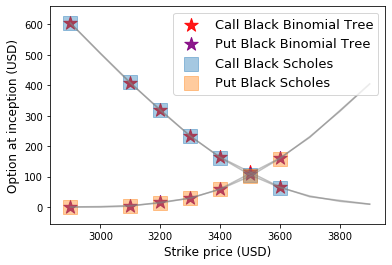

In [267]:
def call_put_strikes(N):
    call_price_BinTree,put_price_BinTree,call_price_BS,put_price_BS = get_data(N)
    
    plt.figure(figsize=(6,4))
    plt.scatter(N, call_price_BinTree, label='Call Black Binomial Tree',marker='*',alpha=0.9,s=200,color='red')
    plt.scatter(N, put_price_BinTree, label='Put Black Binomial Tree',marker='*',alpha=0.9,s=200,color='purple')
    
    plt.scatter(N, call_price_BS, label='Call Black Scholes',marker='s',alpha=0.4,s=200)
    plt.scatter(N, put_price_BS, label='Put Black Scholes',marker='s',alpha=0.4,s=200)
    
    N = np.arange(2900,4000,100)
    call_price_BinTree,put_price_BinTree,call_price_BS,put_price_BS = get_data(N)
    
    
    plt.plot(N, call_price_BinTree, color='grey',alpha=0.5)
    plt.plot(N, put_price_BinTree, color='grey',alpha=0.5)
    
    plt.plot(N, call_price_BS, color='grey',alpha=0.5)
    plt.plot(N, put_price_BS, color='grey',alpha=0.5)
    
    
    plt.legend(loc='best',fontsize=13)
    plt.xlabel('Strike price (USD)', size=12)
    plt.ylabel('Option at inception (USD)',size=12)

    
    plt.savefig('Ex2g.pdf')
    plt.show()
N = [2900,3100,3200,3300,3400,3500,3600]
call_put_strikes(N)

0.04281564231667559


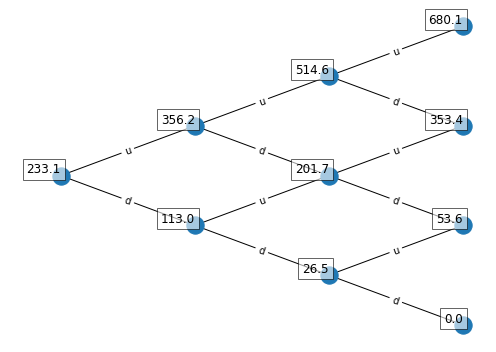

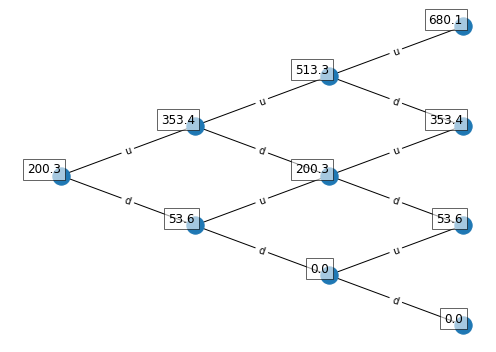

In [272]:
def American_call():
    Binomial_2f = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='call')
    Binomial_2f.plot_graph(Binomial_2f.option_tree, 'call_option_american.pdf')
    Binomial_2f.plot_graph(np.maximum(Binomial_2f.price_tree-3300,0), 'call_exercise_early.pdf')
American_call()

0.04281564231667559


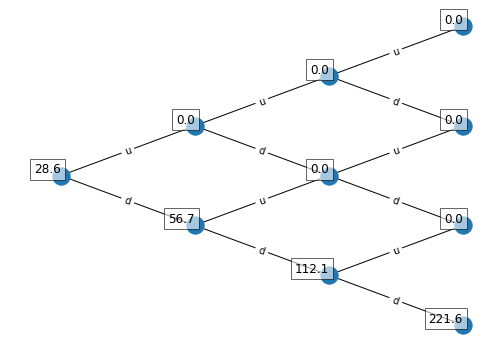

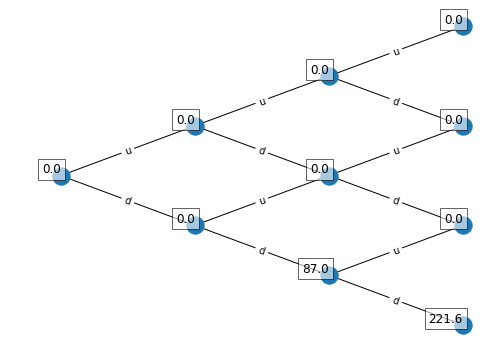

In [271]:
def American_put():
    Binomial_2f = BinomialTree(3,3,startingprice,sigma,0.005,3300,call_put='put')
    Binomial_2f.plot_graph(Binomial_2f.option_tree, 'put_option_american.pdf')
    Binomial_2f.plot_graph(np.maximum(3300-Binomial_2f.price_tree,0), 'put_exercise_early.pdf')
American_put()

In [275]:
u=np.exp(sigma)
d=1/u


In [276]:
(1+0.005/12-d)/(u-d) - 0.01/3*((1+0.005/12-d)/(u-d)*(1-(1+0.005/12-d)/(u-d)))**(1/2)

0.4924955078202916